In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets

from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [3]:
# Download training from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
# Size of training and testing dataset
print(len(training_data))
print(len(test_data))

# Create data loader for training and testing
train_loader = DataLoader(training_data, 200, shuffle=True)
test_loader = DataLoader(test_data, len(test_data))
train_eval_loader = DataLoader(training_data, len(training_data))

60000
10000


In [19]:
# This can take some time to run
X_train_full, y_train_full = next(iter(train_eval_loader))

In [6]:
# Function to evaluate the performence
def evaluate(y_preds, y_obs):
    return sum(y_preds==y_obs)/len(y_preds)

In [13]:
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # LeNet-5
        # Input image is size 1x28x28
        # First layer of Conv-Sigmoid-MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2), # Output: 28x28x6
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2)      # Output: 14x14x6
        )
        # First layer of Conv-Sigmoid-MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),           # Output: 10x10x16
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2)      # Output: 5x5x16
        )
        # Flatten layer, 
        self.flatten = nn.Sequential(
            nn.Flatten()                   # Output: 5*5*16=400
        )
        self.dense1 = nn.Sequential(
            nn.Linear(in_features=400, out_features=120),
            nn.Sigmoid()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid()
        )
        self.dense3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.dense2(out)
        out = self.dense3(out)
        return out

Epoch: 0, - Training Cost: 1.0073481798171997, - Training Accuracy: 0.5751166939735413
Epoch: 0, - Testing cost: 1.0229209661483765 - Testing Accurarcy: 0.5701000094413757
........

Epoch: 1, - Training Cost: 0.501456618309021, - Training Accuracy: 0.810366690158844
Epoch: 1, - Testing cost: 0.5327773690223694 - Testing Accurarcy: 0.7968999743461609
........

Epoch: 2, - Training Cost: 0.42905062437057495, - Training Accuracy: 0.8411333560943604
Epoch: 2, - Testing cost: 0.4591990113258362 - Testing Accurarcy: 0.8288000226020813
........

Epoch: 3, - Training Cost: 0.3632851243019104, - Training Accuracy: 0.8673999905586243
Epoch: 3, - Testing cost: 0.40396177768707275 - Testing Accurarcy: 0.8489999771118164
........

Epoch: 4, - Training Cost: 0.35806286334991455, - Training Accuracy: 0.866016685962677
Epoch: 4, - Testing cost: 0.4047818183898926 - Testing Accurarcy: 0.8496000170707703
........

Epoch: 5, - Training Cost: 0.32530996203422546, - Training Accuracy: 0.8793500065803528
Ep

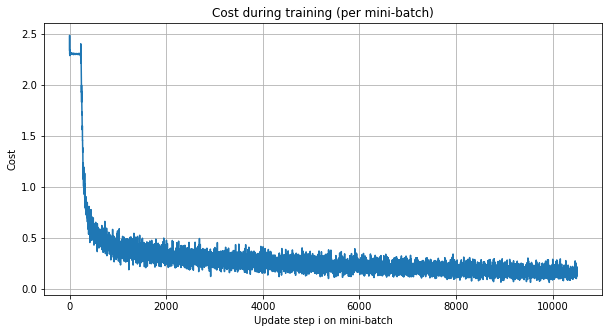

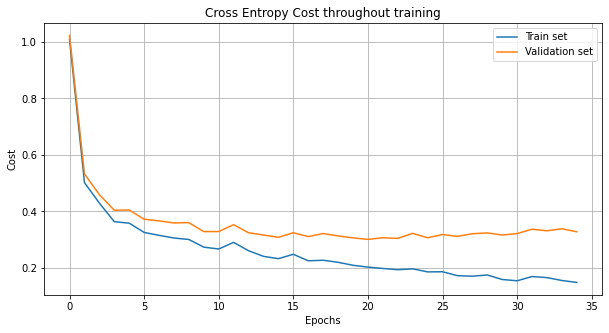

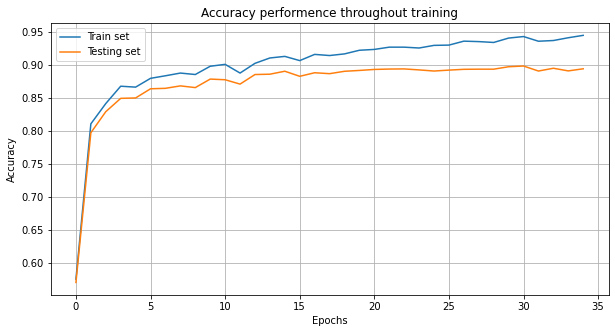

In [14]:
# Create instance of net
model = NeuralNetwork()

# Select the optimizer
#optim = torch.optim.SGD(model.parameters(), lr=0.5)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Cost function is MSE, same for all five architectures to be tested
cost_function = nn.CrossEntropyLoss()

# Train the netwoek
training_minibatch_Js = []
training_epochs_Js = []
train_epoch_acc = []
testing_epoch_Js = []
testing_epoch_acc = []

nr_epochs = 35
batch_count = 0
for epoch_i in range(nr_epochs):
    for X_batch, y_batch in train_loader:
        #print(f"Batch number: {batch_count}")
        batch_count += 1
        # Train using gradient Descent
        
        # Make a prediction on the minibatch
        y_preds = model(X_batch)
                        
        # Calculate the cost
        cost = cost_function(y_preds, y_batch)
        
        # Add curent cost so it can be plotted
        training_minibatch_Js.append(cost)
        
        # Zero the gradient
        optim.zero_grad()
        
        # Calculate the gradient
        cost.backward()
        
        # Take a step in the gradient descent direction
        optim.step()
        
    # Test data
    for X_test_batch, y_test_batch in test_loader:
        with torch.no_grad():
            raw_y_preds_test = model(X_test_batch)
        testing_epoch_Js.append(cost_function(raw_y_preds_test, y_test_batch))
   
        y_test_pred = raw_y_preds_test.argmax(dim=1)
        testing_epoch_acc.append(evaluate(y_test_pred, y_test_batch))
    
    with torch.no_grad():
        raw_y_preds_train = model(X_train_full)
    training_epochs_Js.append(cost_function(raw_y_preds_train, y_train_full))
   
    y_train_pred = raw_y_preds_train.argmax(dim=1)
    
    train_epoch_acc.append(evaluate(y_train_pred, y_train_full))
    
    
    print(f"Epoch: {epoch_i}, - Training Cost: {training_epochs_Js[-1]}, - Training Accuracy: {train_epoch_acc[-1]}")
    print(f"Epoch: {epoch_i}, - Testing cost: {testing_epoch_Js[-1]} - Testing Accurarcy: {testing_epoch_acc[-1]}")
    print("........")
    print("")
        
# Plot cost during training
plt.figure(figsize=[10, 5])
plt.plot(training_minibatch_Js)
plt.xlabel("Update step i on mini-batch")
plt.ylabel("Cost")
plt.title("Cost during training (per mini-batch)")
plt.grid()
print(training_minibatch_Js[-1])

# Plot the Cross Entropy Loss
plt.figure(figsize=[10, 5])
plt.plot(training_epochs_Js, label="Train set")
plt.plot(testing_epoch_Js, label="Validation set")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cross Entropy Cost throughout training")
plt.legend()
plt.grid()

# Plot the accuracy
plt.figure(figsize=[10, 5])
plt.plot(train_epoch_acc, label="Train set")
plt.plot(testing_epoch_acc, label="Testing set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy performence throughout training")
plt.legend()
plt.grid()
    

In [17]:
# Define the model2
# Smaller than LeNet-5
class NeuralNetwork_2(nn.Module):
    def __init__(self):
        super(NeuralNetwork_2, self).__init__()
        
        # LeNet-5
        # Input image is size 1x28x28
        # First layer of Conv-Sigmoid-MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 5, 5), # Output: 5x24x24
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2)      # Output: 5x12x12
        )
        # First layer of Conv-Sigmoid-MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(5, 12, 3),           # Output: 12x10x10
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2)      # Output: 12x5x5
        )
        # Flatten layer, 
        self.flatten = nn.Sequential(
            nn.Flatten()                   # Output: 12*5*5=300
        )
        self.dense1 = nn.Sequential(
            nn.Linear(in_features=300, out_features=120),
            nn.Sigmoid()
        )
        self.dense2 = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid()
        )
        self.dense3 = nn.Sequential(
            nn.Linear(in_features=84, out_features=10)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.dense2(out)
        out = self.dense3(out)
        return out

Epoch: 0, - Training Cost: 0.6625499725341797, - Training Accuracy: 0.742900013923645
Epoch: 0, - Testing cost: 0.6852166056632996 - Testing Accurarcy: 0.7368999719619751
........

Epoch: 1, - Training Cost: 0.4797232449054718, - Training Accuracy: 0.8198500275611877
Epoch: 1, - Testing cost: 0.5163590312004089 - Testing Accurarcy: 0.807699978351593
........

Epoch: 2, - Training Cost: 0.4253629446029663, - Training Accuracy: 0.8433666825294495
Epoch: 2, - Testing cost: 0.46100670099258423 - Testing Accurarcy: 0.8330000042915344
........

Epoch: 3, - Training Cost: 0.3890715539455414, - Training Accuracy: 0.8551166653633118
Epoch: 3, - Testing cost: 0.42230987548828125 - Testing Accurarcy: 0.8453999757766724
........

Epoch: 4, - Training Cost: 0.4047478139400482, - Training Accuracy: 0.8502166867256165
Epoch: 4, - Testing cost: 0.44106122851371765 - Testing Accurarcy: 0.8396000266075134
........

Epoch: 5, - Training Cost: 0.3563312888145447, - Training Accuracy: 0.8685166835784912
Ep

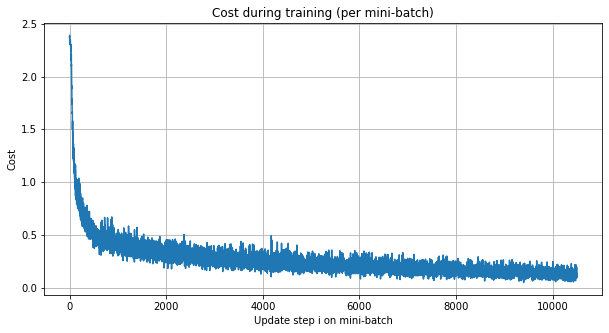

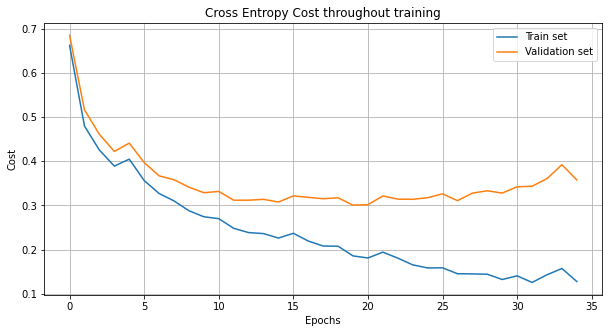

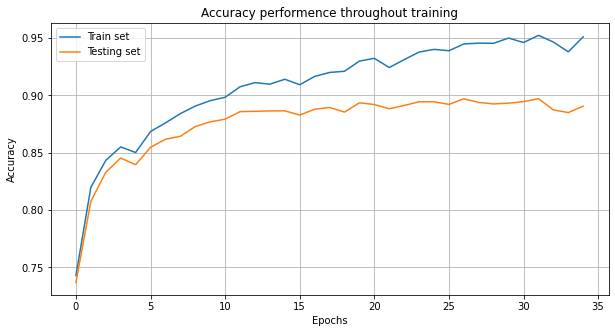

In [18]:
# Create instance of net
model2 = NeuralNetwork_2()

# Select the optimizer
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model2.parameters(), lr=learning_rate)

# Cost function is MSE, same for all five architectures to be tested
cost_function = nn.CrossEntropyLoss()

# Train the netwoek
training_minibatch_Js = []
training_epochs_Js = []
train_epoch_acc = []
testing_epoch_Js = []
testing_epoch_acc = []

nr_epochs = 35
for epoch_i in range(nr_epochs):
    for X_batch, y_batch in train_loader:
        # Train using gradient Descent
        
        # Make a prediction on the minibatch
        y_preds = model2(X_batch)
                        
        # Calculate the cost
        cost = cost_function(y_preds, y_batch)
        
        # Add curent cost so it can be plotted
        training_minibatch_Js.append(cost)
        
        # Zero the gradient
        optim.zero_grad()
        
        # Calculate the gradient
        cost.backward()
        
        # Take a step in the gradient descent direction
        optim.step()
        
    # Test data each epoch
    for X_test_batch, y_test_batch in test_loader:
        with torch.no_grad():
            raw_y_preds_test = model2(X_test_batch)
        # Calculate cost of test data
        testing_epoch_Js.append(cost_function(raw_y_preds_test, y_test_batch))
   
        y_test_pred = raw_y_preds_test.argmax(dim=1)
        # Calculate accuracy of test data
        testing_epoch_acc.append(evaluate(y_test_pred, y_test_batch))
    
    # Train data each epoch
    with torch.no_grad():
        raw_y_preds_train = model2(X_train_full)
    # Calculate cost of train data
    training_epochs_Js.append(cost_function(raw_y_preds_train, y_train_full))
   
    y_train_pred = raw_y_preds_train.argmax(dim=1)
    # Calculate accuracy of train data
    train_epoch_acc.append(evaluate(y_train_pred, y_train_full))
    
    # Print performence for each epoch
    print(f"Epoch: {epoch_i}, - Training Cost: {training_epochs_Js[-1]}, - Training Accuracy: {train_epoch_acc[-1]}")
    print(f"Epoch: {epoch_i}, - Testing cost: {testing_epoch_Js[-1]} - Testing Accurarcy: {testing_epoch_acc[-1]}")
    print("........")
    print("")
        
# Plot cost during training
plt.figure(figsize=[10, 5])
plt.plot(training_minibatch_Js)
plt.xlabel("Update step i on mini-batch")
plt.ylabel("Cost")
plt.title("Cost during training (per mini-batch)")
plt.grid()
print(training_minibatch_Js[-1])

# Plot the Cross Entropy Loss
plt.figure(figsize=[10, 5])
plt.plot(training_epochs_Js, label="Train set")
plt.plot(testing_epoch_Js, label="Validation set")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cross Entropy Cost throughout training")
plt.legend()
plt.grid()

# Plot the accuracy
plt.figure(figsize=[10, 5])
plt.plot(train_epoch_acc, label="Train set")
plt.plot(testing_epoch_acc, label="Testing set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy performence throughout training")
plt.legend()
plt.grid()